In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../../../data/final/dtdata.csv', index_col=0)

In [50]:
new_column_names = ['seccio', 'altmax', 'amplmax', 'perime', 'Longitud', 'Velocitat',
                   'AltAigua', 'Cabal', 'seccio_1', 'altmax_1', 'amplmax_1', 'perime_1',
                   'Longitud_1', 'Velocitat_1', 'AltAigua_1', 'Cabal_1', 'seccio_2',
                   'altmax_2', 'amplmax_2', 'perime_2', 'Longitud_2', 'Velocitat_2',
                   'AltAigua_2', 'Cabal_2', 'seccio_3', 'altmax_3', 'amplmax_3',
                   'perime_3', 'Longitud_3', 'Velocitat_3', 'AltAigua_3', 'Cabal_3',
                   'seccio_4', 'altmax_4', 'amplmax_4', 'perime_4', 'Longitud_4',
                   'Velocitat_4', 'AltAigua_4', 'Cabal_4', 'seccio_5', 'altmax_5',
                   'amplmax_5', 'perime_5', 'Longitud_5', 'Velocitat_5', 'AltAigua_5',
                   'Cabal_5', 'barri']

# Get the current column names
current_column_names = df.columns

# Replace the names of the last 49 columns
df.columns = current_column_names[:-49].tolist() + new_column_names
df.drop('value_2', axis=1, inplace=True)

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.datasets import make_classification
import shap
import dtreeviz
from dtreeviz import decision_boundaries

# Training a tree with only the features of the section to be predicted

In [52]:
X = df.drop(df.filter(regex=("(_[0-5]_[0-5]|_[2-5])")).columns, 
        axis=1)
y= X['value_y']
X.drop(['amount_rain_std_1', 'amount_rain_mean_1', 'altmax_1',
        'Longitud_1', 'Velocitat_1', 'Cabal_1', 'value_y',
        'seccio_1', 'amplmax_1', 'perime_1', 'AltAigua_1'],
       axis=1, inplace=True)

In [53]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)

In [54]:
model_1 = DecisionTreeClassifier(**{'max_depth': 7, 'max_features': 0.794612916790575, 'min_samples_leaf': 12, 'min_samples_split': 19, 'random_state': 4})
model_1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, max_features=0.794612916790575,
                       min_samples_leaf=12, min_samples_split=19,
                       random_state=4)

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Predict using the best model
y_pred_test_expanded = model_1.predict(X_test)
y_prob_test_expanded = model_1.predict_proba(X_test)[:, 1]

# Calculate the performance metrics for the test set
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_test_expanded),
    'Precision': precision_score(y_test, y_pred_test_expanded),
    'Recall': recall_score(y_test, y_pred_test_expanded),
    'F1 Score': f1_score(y_test, y_pred_test_expanded),
    'ROC-AUC': roc_auc_score(y_test, y_prob_test_expanded)
}

test_metrics

{'Accuracy': 0.7643979057591623,
 'Precision': 0.6710526315789473,
 'Recall': 0.7183098591549296,
 'F1 Score': 0.6938775510204082,
 'ROC-AUC': 0.797593896713615}

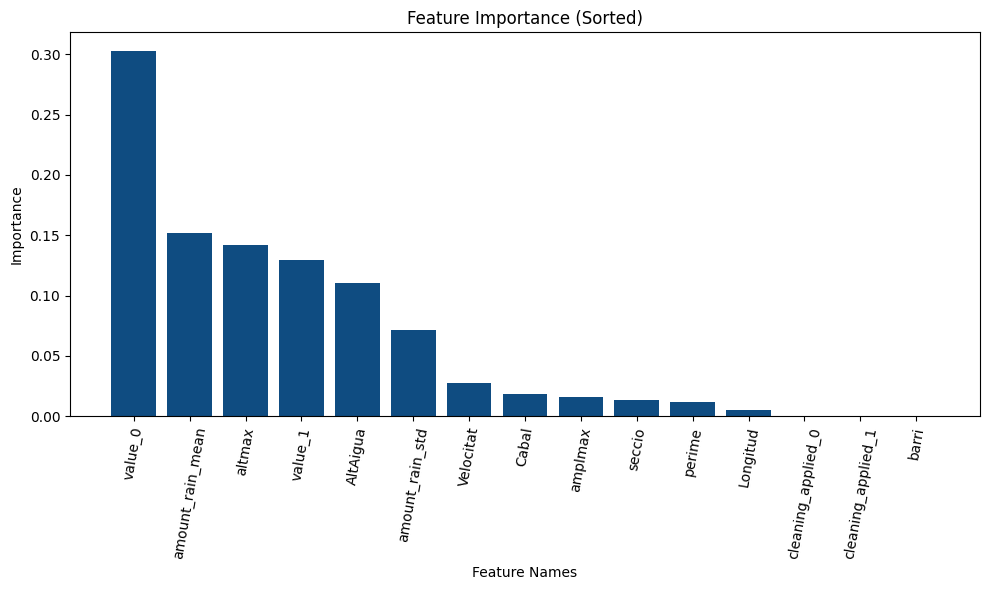

In [56]:
feature_names = X.columns
importance_values = model_1.feature_importances_

sorted_indices = sorted(range(len(importance_values)), key=lambda k: importance_values[k], reverse=True)
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_values = [importance_values[i] for i in sorted_indices]

# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance_values, color='#0f4c81')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.title('Feature Importance (Sorted)')
plt.xticks(rotation=80)
plt.tight_layout()

# Display the plot
plt.show()

In [57]:
explainer = shap.TreeExplainer(model_1)

# Compute SHAP values
shap_values = explainer.shap_values(X)

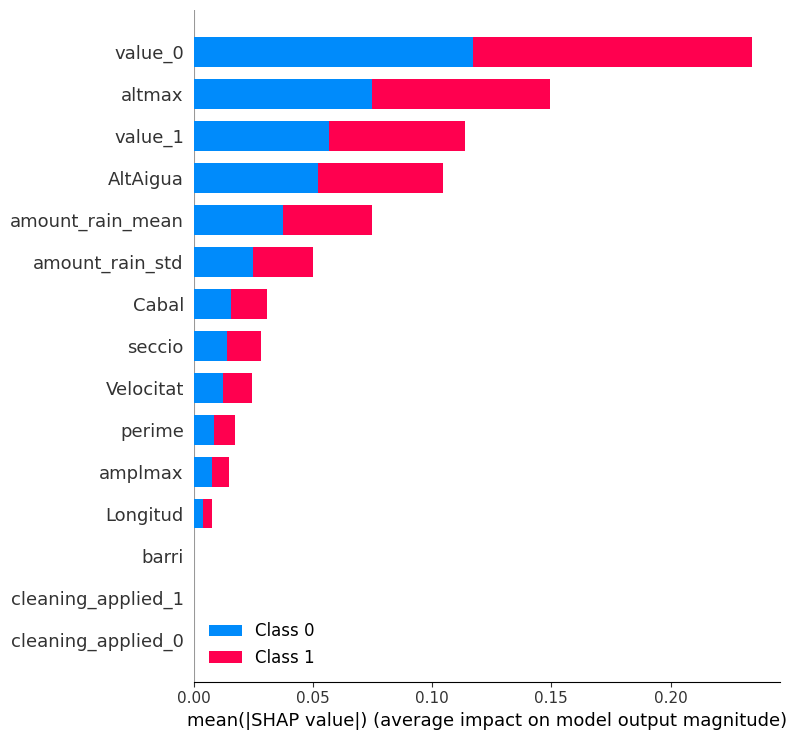

In [58]:
# Plot summary plot for overall impact of each feature on the model output
shap.summary_plot(shap_values, X, plot_type="bar")

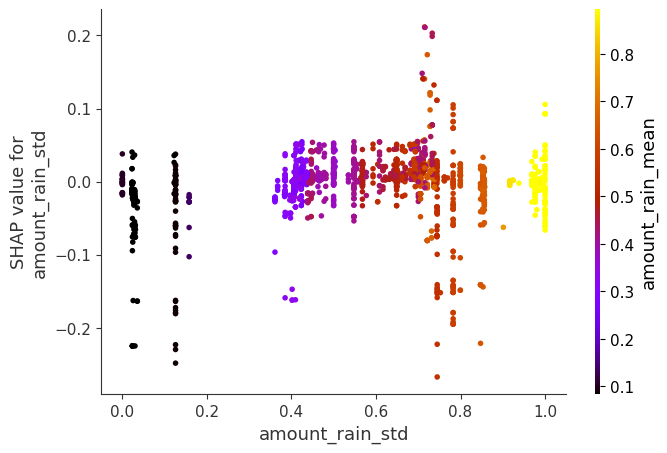

In [59]:
shap.dependence_plot(1, shap_values[0], X, feature_names= feature_names, interaction_index=0, cmap='gnuplot')
plt.show()

In [66]:
explanation = shap.Explanation(values=shap_values[0][1388], base_values=explainer.expected_value[0], feature_names=X.columns)

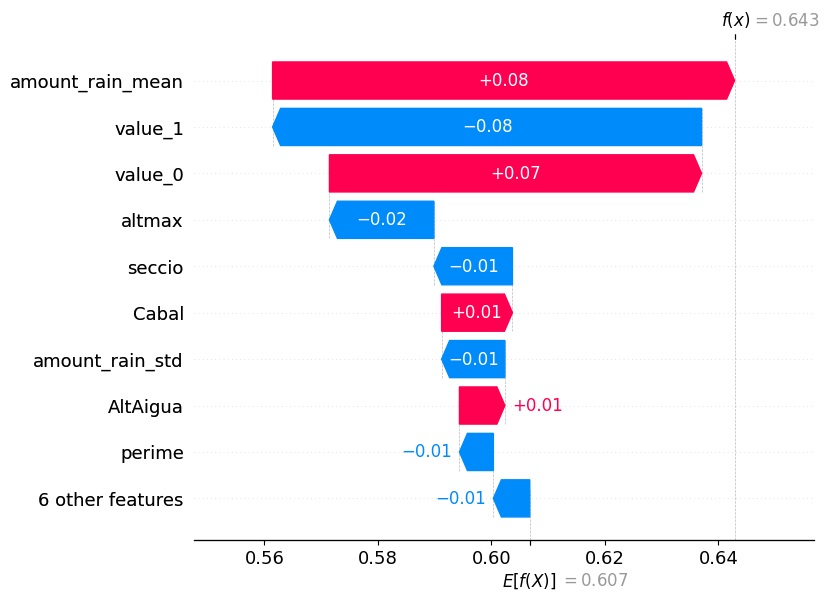

In [67]:
shap.plots.waterfall(explanation)

In [62]:
explanation = shap.Explanation(values=shap_values[0][1712], base_values=explainer.expected_value[0], feature_names=X.columns)

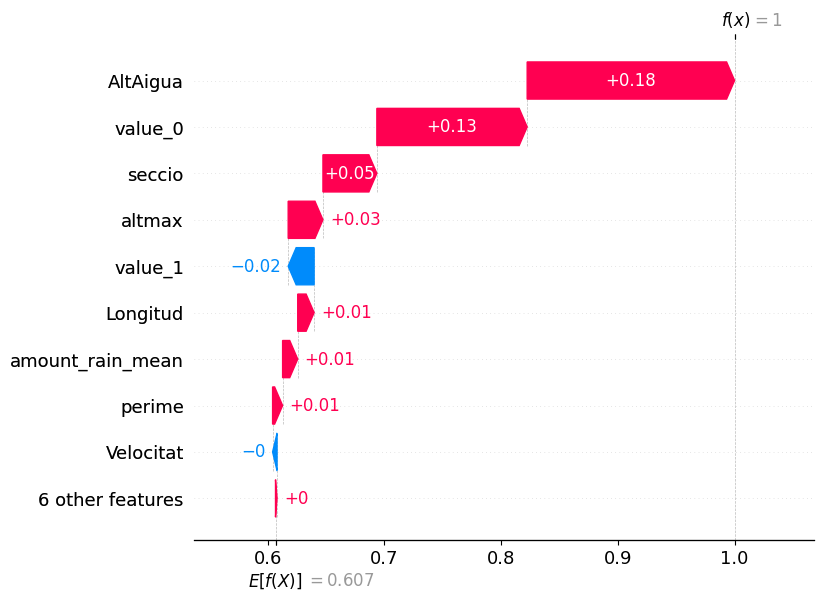

In [63]:
shap.plots.waterfall(explanation)

In [18]:
viz_model = dtreeviz.model(model_1,
                           X_train=X, 
                           y_train=y,
                           feature_names=list(X.columns),
                           target_name='value_y',
                           class_names=y.unique().astype(str))

In [19]:
X.loc[(X.amount_rain_std>0.9)&
     (X.value_1>0.05)&
     (X.altmax<0.4)&
     (X.value_0<0.05)].index

Index([695, 831, 1273, 1352, 1388, 1399, 1468, 1477, 1507, 1510, 1515, 1520,
       1527],
      dtype='int64')

In [20]:
model_1.predict(X.loc[(X.amount_rain_std>0.9)&
     (X.value_1>0.05)&
     (X.altmax<0.4)&
     (X.value_0<0.05)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

/Users/marc.ribalta/anaconda3/envs/phd/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


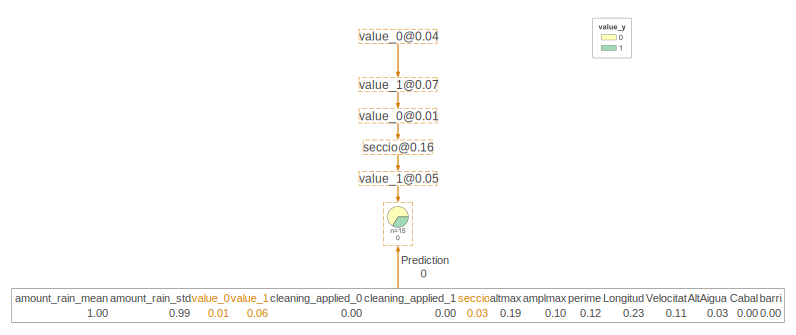

In [21]:
viz_model.view(x=X.iloc[1388], show_just_path=True, fancy=False)

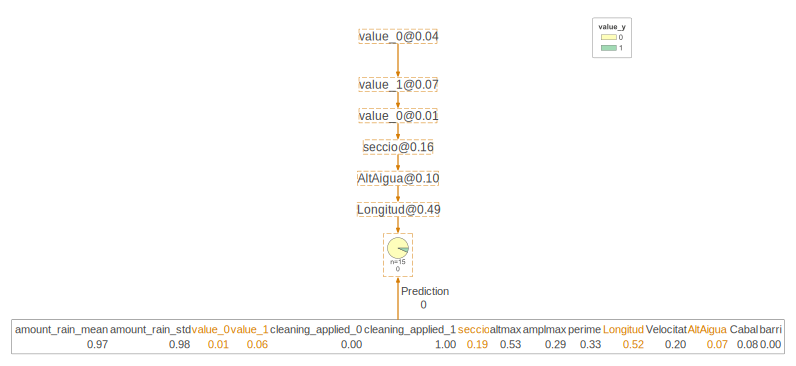

In [22]:
viz_model.view(x=X.iloc[1712], show_just_path=True, fancy=False)

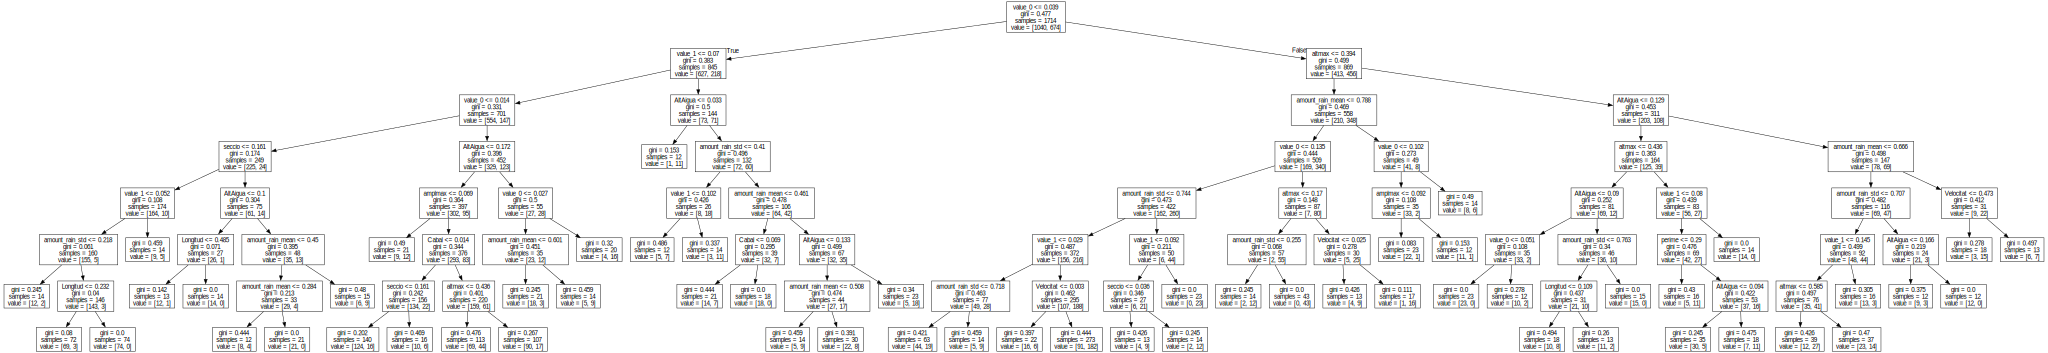

In [23]:
import graphviz
from sklearn import tree

tree_graph = tree.export_graphviz(model_1, out_file=None, feature_names=X.columns)
graphviz.Source(tree_graph)

# Best possible decision tree

The idea is to get the best possible tree, hyperparameter and feature - wise.

In [24]:
X = df.drop(columns=['value_y'])
y = df['value_y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [25]:
best_features_global = ['amount_rain_std', 'value_1_5', 'value_1_3', 'value_1_2', 'altmax', 'value_1', 'Velocitat', 'amount_rain_mean_1', 'Longitud_1']

In [26]:
model_2 = DecisionTreeClassifier(**{'max_depth': 16, 'max_features': 0.9360168327534356, 'min_samples_leaf': 5, 'min_samples_split': 11, 'random_state': 4})
model_2.fit(X_train[best_features_global], y_train)

DecisionTreeClassifier(max_depth=16, max_features=0.9360168327534356,
                       min_samples_leaf=5, min_samples_split=11,
                       random_state=4)

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Predict using the best model
y_pred_test_expanded = model_2.predict(X_test[best_features_global])
y_prob_test_expanded = model_2.predict_proba(X_test[best_features_global])[:, 1]

# Calculate the performance metrics for the test set
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_test_expanded),
    'Precision': precision_score(y_test, y_pred_test_expanded),
    'Recall': recall_score(y_test, y_pred_test_expanded),
    'F1 Score': f1_score(y_test, y_pred_test_expanded),
    'ROC-AUC': roc_auc_score(y_test, y_prob_test_expanded)
}

test_metrics

{'Accuracy': 0.7801047120418848,
 'Precision': 0.7341772151898734,
 'Recall': 0.7341772151898734,
 'F1 Score': 0.7341772151898734,
 'ROC-AUC': 0.7971858047016276}

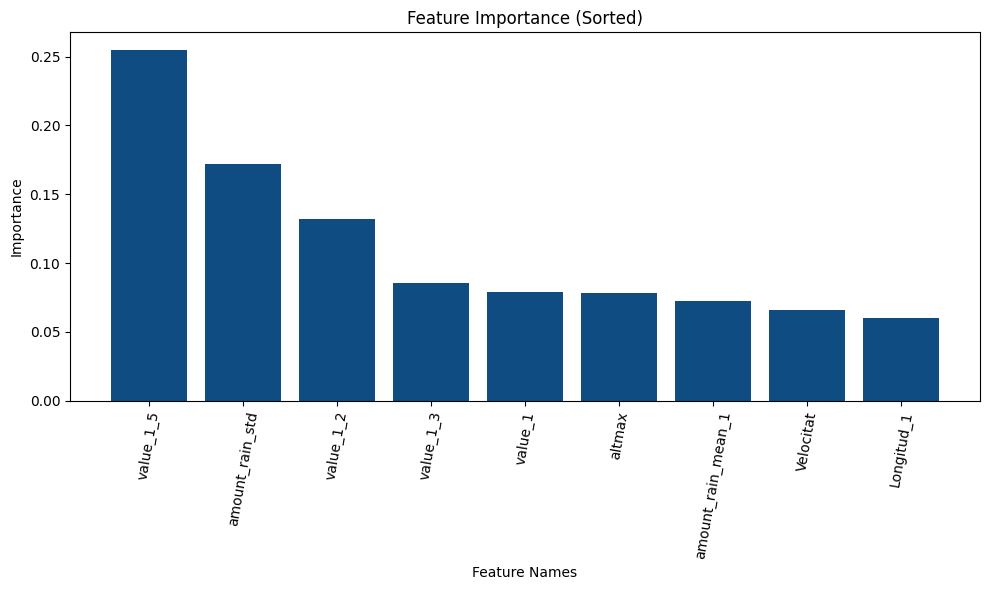

In [28]:
feature_names = best_features_global
importance_values = model_2.feature_importances_

sorted_indices = sorted(range(len(importance_values)), key=lambda k: importance_values[k], reverse=True)
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_values = [importance_values[i] for i in sorted_indices]

# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance_values, color='#0f4c81')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.title('Feature Importance (Sorted)')
plt.xticks(rotation=80)
plt.tight_layout()

# Display the plot
plt.show()

In [29]:
explainer = shap.TreeExplainer(model_2)

# Compute SHAP values
shap_values = explainer.shap_values(X[best_features_global].values)

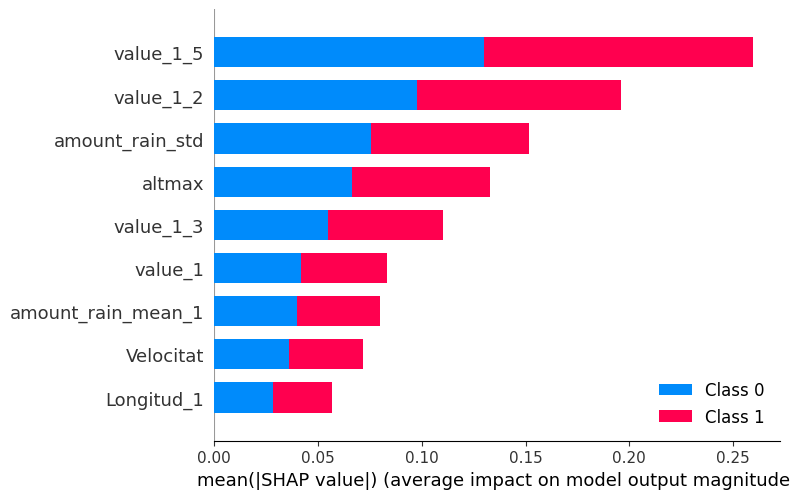

In [30]:
# Plot summary plot for overall impact of each feature on the model output
shap.summary_plot(shap_values, X_test[best_features_global], plot_type="bar")

In [31]:
explanation = shap.Explanation(values=shap_values[0][1388], base_values=explainer.expected_value[0], feature_names=best_features_global)

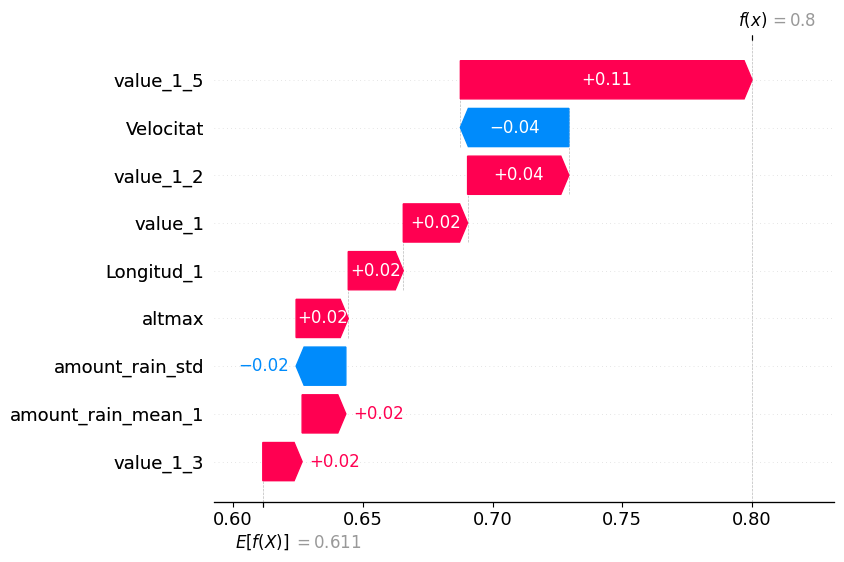

In [32]:
shap.plots.waterfall(explanation)

In [33]:
explanation = shap.Explanation(values=shap_values[0][1712], base_values=explainer.expected_value[0], feature_names=best_features_global)

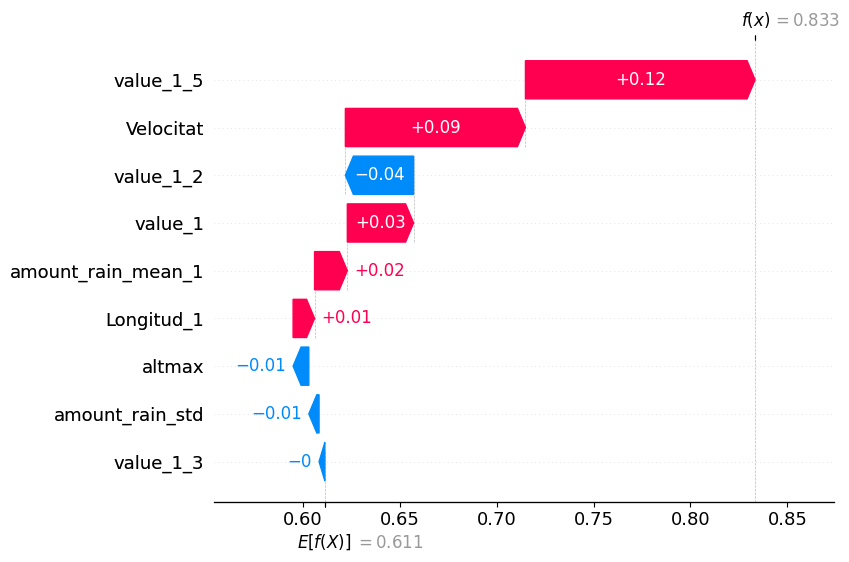

In [34]:
shap.plots.waterfall(explanation)

In [35]:
X.loc[(X.amount_rain_std>0.9)&
     (X.value_1>0.05)&
     (X.altmax>0.5)&
     (X.value_0<0.05)].index

Index([1661, 1667, 1673, 1712], dtype='int64')

In [36]:
model_2.predict(X.loc[(X.amount_rain_std>0.9)&
     (X.value_1>0.05)&
     (X.altmax>0.5)&
     (X.value_0<0.05), best_features_global])

array([0, 0, 0, 0])

In [37]:
viz_model = dtreeviz.model(model_2,
                           X_train=X[best_features_global], 
                           y_train=y,
                           feature_names=list(best_features_global),
                           target_name='value_y',
                           class_names=y.unique().astype(str))

/Users/marc.ribalta/anaconda3/envs/phd/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


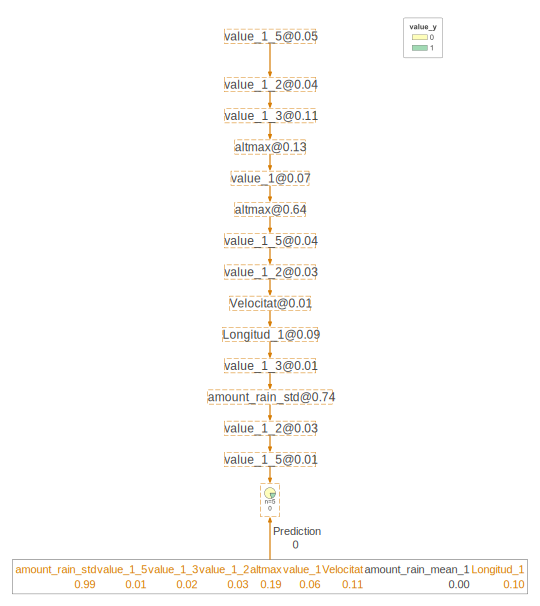

In [38]:
viz_model.view(x=X.iloc[1388][best_features_global], show_just_path=True, fancy=False)

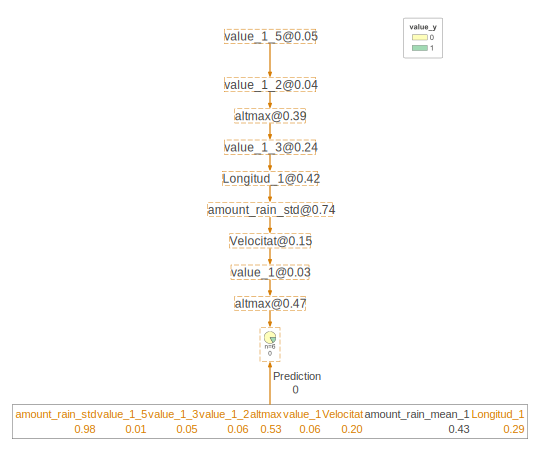

In [39]:
viz_model.view(x=X.iloc[1712][best_features_global], show_just_path=True, fancy=False)

In [40]:
df.iloc[1388].value_y

0.0

In [41]:
df.iloc[1399].value_y

1.0

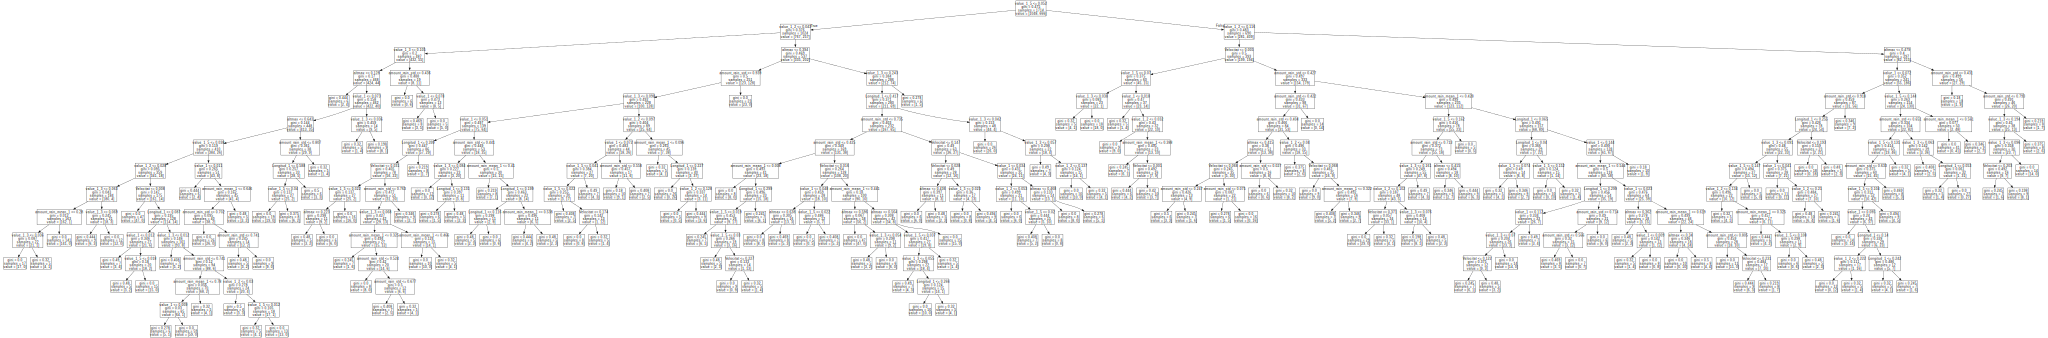

In [42]:
tree_graph = tree.export_graphviz(model_2, out_file=None, feature_names=best_features_global)
graphviz.Source(tree_graph)